In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename = 'data/sfpd_clean.csv'
sfdata = pd.read_csv(filename)

In [3]:
sfdata.head()

,Unnamed: 0,Unnamed: 0.1,Category,Descript,DayOfWeek,PdDistrict,Address,X,Y,Location,CrimeCat,Hour,Month,Day,Year,zipcode
0,0,3,ROBBERY,"ROBBERY, BODILY FORCE",4,SOUTHERN,0 Block of UNITEDNATIONS PZ,-122.414318,37.779944,"(37.7799444052046, -122.414317857881)",2,21,6,16,2016,94102
1,1,6,ASSAULT,ELDER ADULT OR DEPENDENT ABUSE (NOT EMBEZZLEME...,5,NORTHERN,300 Block of FULTON ST,-122.422536,37.778796,"(37.7787958771466, -122.422536478306)",4,12,1,2,2015,94102
2,2,9,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,5,INGLESIDE,600 Block of LONDON ST,-122.437928,37.719328,"(37.7193276406568, -122.43792838007)",1,0,1,16,2015,94112
3,3,12,VEHICLE THEFT,STOLEN MOTORCYCLE,5,BAYVIEW,700 Block of SILLIMAN ST,-122.412481,37.729247,"(37.729246748441, -122.412480611343)",5,0,1,16,2015,94134
4,4,17,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,3,SOUTHERN,0 Block of FOLSOM ST,-122.390556,37.790475,"(37.7904750361645, -122.39055604599)",1,18,1,7,2015,94105


In [15]:
sfdf = sfdata.groupby(['Year', 'zipcode', 'CrimeCat'])['Unnamed: 0'].count()
sfdf = sfdf.unstack().reset_index()
sfdf.fillna(0, inplace=True)

In [5]:
sfdf.head()

CrimeCat,Year,Month,zipcode,1,2,3,4,5,6,7,9,10
0,2003,1,94014,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1,2003,1,94102,286.0,43.0,327.0,145.0,64.0,37.0,28.0,4.0,11.0
2,2003,1,94103,260.0,26.0,200.0,134.0,117.0,48.0,37.0,9.0,4.0
3,2003,1,94104,21.0,5.0,0.0,7.0,0.0,4.0,5.0,0.0,0.0
4,2003,1,94105,61.0,0.0,3.0,11.0,10.0,9.0,2.0,0.0,0.0


In [16]:
from sklearn.preprocessing import MinMaxScaler
X = sfdf.drop(['Year', 'zipcode'], axis=1).values
scaler = MinMaxScaler()
X_sca = scaler.fit_transform(X)

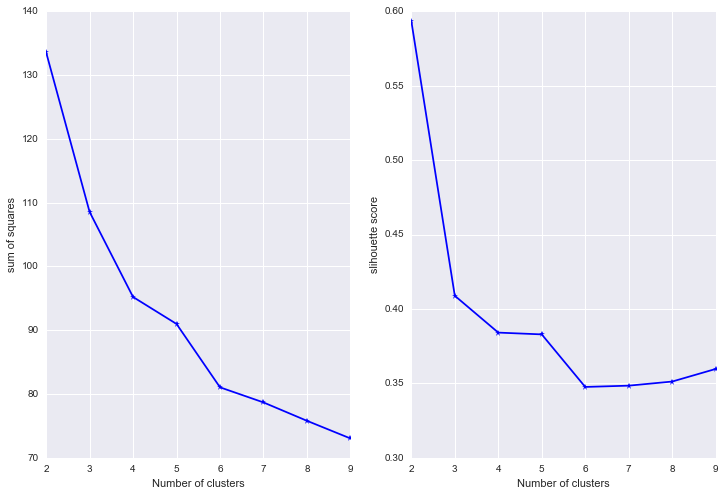

In [17]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
%matplotlib inline

scaler = StandardScaler()
X_trans = scaler.fit_transform(X)
def kmeans_all(X):
    dists = []
    scores = []
    for k in xrange(2, 10):
#         print k
        kmeanModel = KMeans(k)
        kmeanModel.fit(X)
        centroids = kmeanModel.cluster_centers_
        labels = kmeanModel.labels_
        dist = cdist(X, centroids)
        dists.append(dist.min(axis=1).sum())
        score = silhouette_score(X, labels)
        scores.append(score)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(121)
    ax1.plot(xrange(2, 10), dists, 'b*-')
    ax1.grid(True)
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('sum of squares')
    ax2 = fig.add_subplot(122)
    ax2.plot(xrange(2, 10), scores, 'b*-')
    ax2.grid(True)
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('slihouette score')
    plt.show()


def get_ref(shape, tops, bots): 
    dists = tops - bots
    ref = np.random.random(shape) * dists + bots
    return ref

def iter_kmeans(refs, k):
    vals = []
    for ref in refs:
        model = KMeans(n_clusters=k, n_init=3)
        model.fit(ref)
        vals.append(np.log(model.inertia_))
    return np.array(vals)

def gap_statistic(X, max_k=10, B=10):
    gaps = []
    gaps_minus = []
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    refs = [get_ref(X.shape, tops, bots) for i in xrange(B)]
#     print refs
    for k in range(1, max_k + 1):
        km_act = KMeans(n_clusters=k, n_init=3)
        km_act.fit(X)
        ref_log_inertias = iter_kmeans(refs, k)       
        sdk = np.std(ref_log_inertias)
#         print sdk
        gap = ref_log_inertias.mean() - np.log(km_act.inertia_)
        sk = np.sqrt(1 + 1.0/B) * sdk
#         print sk
#         print "Ref: %s   Act: %s  Gap: %s" % ( ref_inertia, km_act.inertia_, gap)
        gaps.append(gap)
        gaps_minus.append(gap - sk)
    plt.figure()
    plt.plot(range(1, max_k+1), gaps, label='Gap(k)')
    plt.plot(range(max_k), gaps_minus, label='Gap(k+1) - s(k+1)')
    plt.legend(loc='best')
    plt.show()
    return gaps

kmeans_all(X_sca)

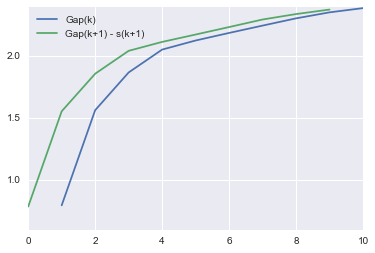

In [23]:
gaps = gap_statistic(X_sca)

In [13]:
crimes = {1: 'Theft/Larcery', 2: 'Robebery', 3: 'Nacotic/Alcochol',
          4: 'Assault', 5: 'Grand Auto Theft', 6: 'Vandalism',
          7: 'Burglary',9: 'Sex Crime', 10: 'DUI'}

def build_nmf_all(X,k):
    nmfModel = NMF(n_components=k)
    W = nmfModel.fit_transform(X)
    H = nmfModel.components_
    print 'NMF done!'
    plot_heatmap(H.T, k)
    return W, H
    

def plot_heatmap(data, k):
    fig, ax = plt.subplots(figsize = (8,8))
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(k)+0.5, minor=False, )
    ax.set_yticks(np.arange(9)+0.5, minor=False)

    # want a more natural, table-like display
#     ax.invert_yaxis()
#     ax.xaxis.tick_top()
    classLabel = ['cls-{}:'.format(i) for i in range(1, k+1)]
    ax.set_xticklabels(classLabel, minor=False)
    ax.set_yticklabels(crimes.values(), minor=False)
    ax.set_title('Heatmap of Lattent Feature')
    plt.show()

def try_different_k_class(X):
    for k in xrange(2, 11):
        build_nmf_all(X, k)

NMF done!


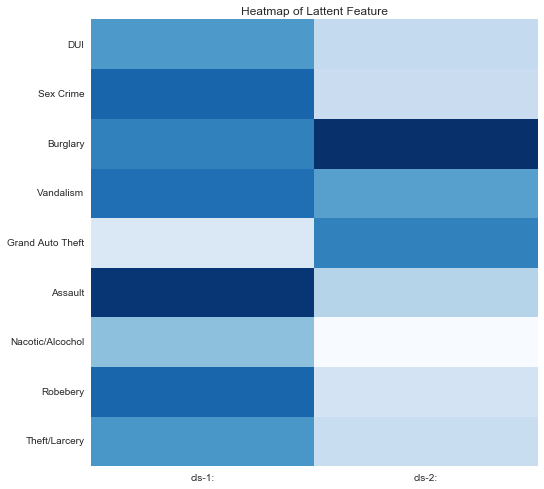

NMF done!


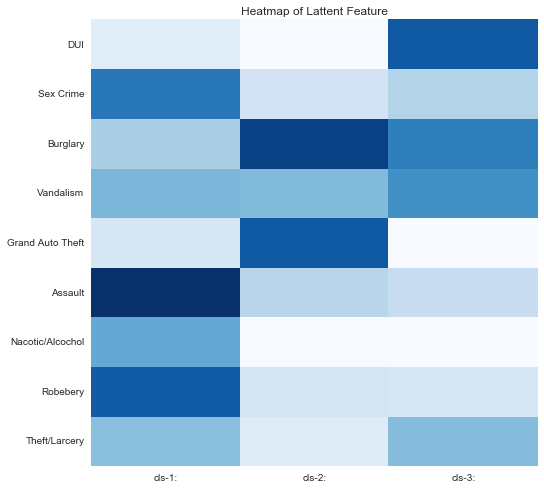

NMF done!


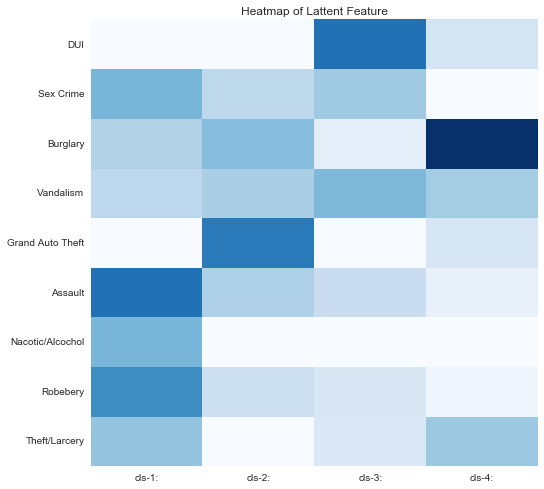

NMF done!


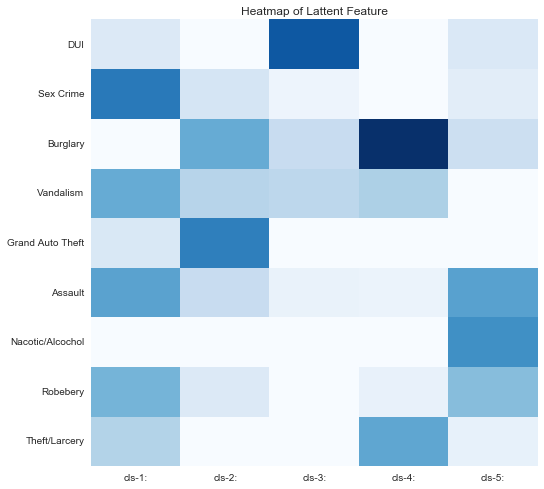

NMF done!


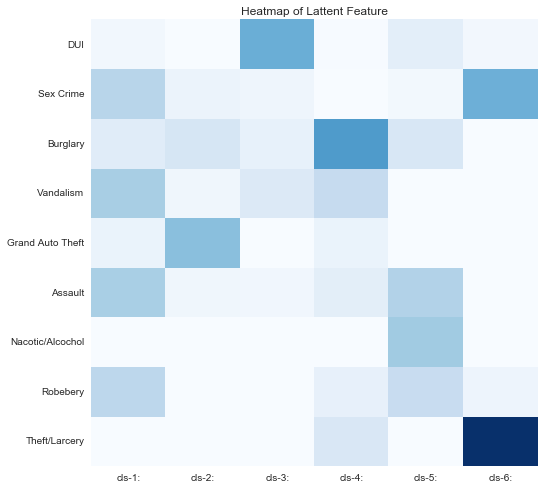

NMF done!


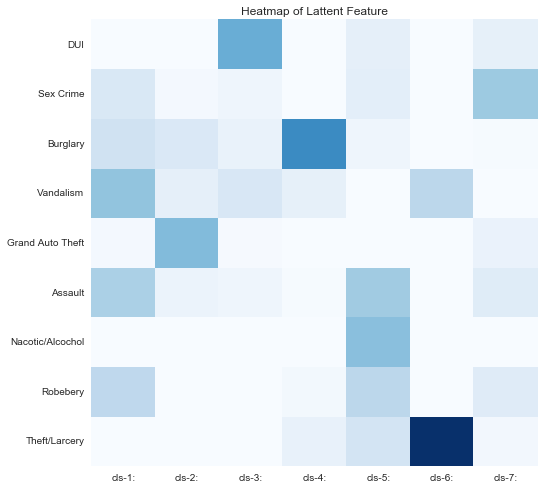

NMF done!


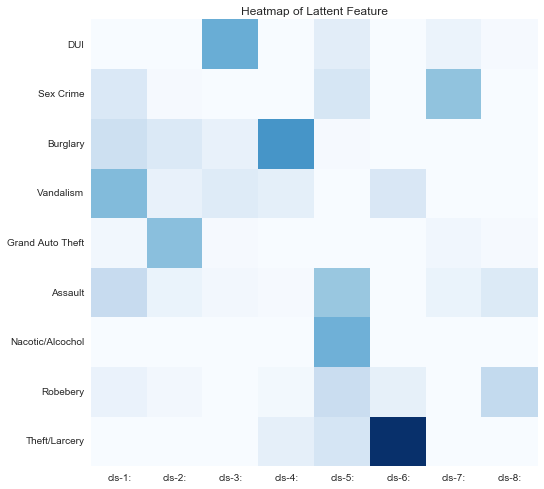

NMF done!


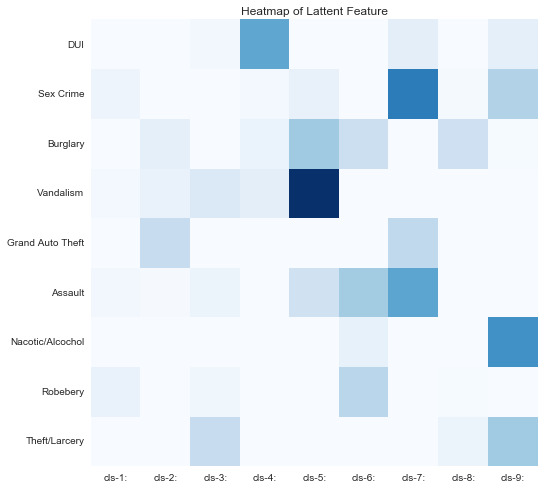

NMF done!


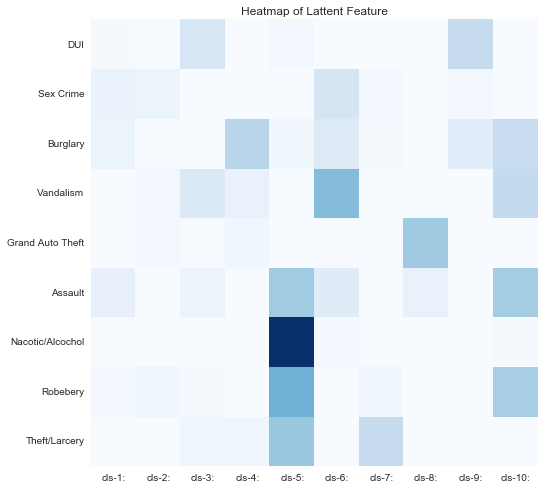

In [18]:
try_different_k_class(X_sca)

In [24]:
def build_kmean(X, k):
    model = KMeans(k, n_init=3)
    model.fit(X)
    centroids = model.cluster_centers_
    labels = model.labels_
    return centroids, labels
centroids, labels = build_kmean(X_sca, 6)
print crimes.values()
for cent in centroids:
    print cent

['Theft/Larcery', 'Robebery', 'Nacotic/Alcochol', 'Assault', 'Grand Auto Theft', 'Vandalism', 'Burglary', 'Sex Crime', 'DUI']
[ 0.04035542  0.0225      0.002637    0.03226328  0.02650728  0.05188414
  0.08096     0.02592242  0.02768959]
[ 0.14284197  0.23475783  0.05348968  0.32431173  0.47485947  0.35582531
  0.49493333  0.23522198  0.1399177 ]
[ 0.56632061  0.73392505  0.59396638  0.905385    0.19726531  0.49992429
  0.82670769  0.51553744  0.32003799]
[ 0.13756817  0.11078339  0.02178323  0.1526394   0.13597375  0.23272426
  0.33155337  0.12208995  0.1626903 ]
[ 0.47823184  0.59787968  0.23352902  0.75842979  0.42295698  0.73728044
  0.70916923  0.73968416  0.55223172]
[ 0.25082143  0.33246606  0.1139632   0.46802747  0.24085851  0.50361857
  0.63063529  0.36131671  0.2962963 ]


NMF done!


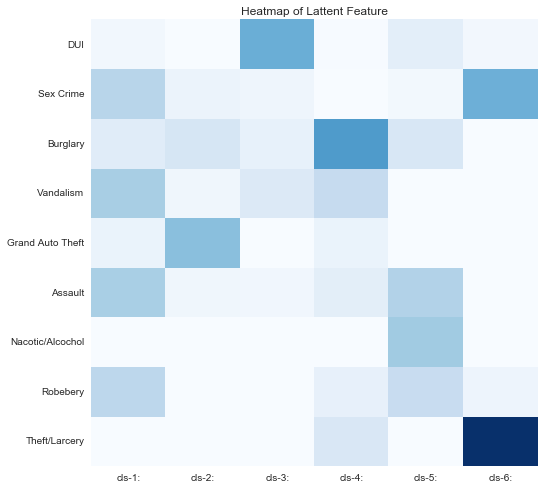

In [25]:
W, H = build_nmf_all(X_sca, 6)

In [28]:
labelsNMF = W.argmax(axis=1)

In [123]:
from mpl_toolkits.basemap import Basemap
import fiona
from shapely.geometry import shape, mapping
from pyproj import Proj, transform
from fiona.crs import from_epsg
from itertools import chain
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from matplotlib.collections import PatchCollection

SFcenter = (-122.4194, 37.7749)
# SFshapefile = 'map/SF-ZipCodes/SFZipCodes'
SFshapefile = 'map/SFFindNeighborhoods/geo_export_d66d1918-4dd9-418b-af5c-3cba0918f56b'
# SFshapefile = 'map/stclines_streets/stclines_streets'
# SFshapefile = 'map/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA'
state = 'map/Bay Area ZIP Codes/geo_export_cd2a0d4c-e556-45fa-8c0d-37dca9d7c0e4'
# shape = fiona.open(SFshapefile + '.shp')

# original = Proj(shape.crs) # EPSG:4326 in your case
# destination = Proj(init='EPSG:4326') # your new EPSG
# with fiona.open('map/SF-ZipCodes/SFZipCodes_new.shp', 'w', 'ESRI Shapefile', shape.schema.copy(), crs=from_epsg(4326)) as output:
#     for feat in shape:
#         out_linearRing = []
# #         print feat
#         for point in feat['geometry']['coordinates'][0]:
# #             if 
#             (lon, lat) = point
            
#             x,y = transform(original, destination,lon,lat)
#             print x, y
#             # change only the coordinates of the feature
#             out_linearRing.append((x,y))
#         feat['geometry']['coordinates'] = [out_linearRing]
#         output.write(feat)

<bound method Collection.keys of <open Collection 'map/SFFindNeighborhoods/geo_export_d66d1918-4dd9-418b-af5c-3cba0918f56b.shp:geo_export_d66d1918-4dd9-418b-af5c-3cba0918f56b', mode 'r' at 0x11e00c310>>

(187,
 5,
 [-122.80441700099175, 37.25218999903195, 0.0, 0.0],
 [-121.4038420032024, 38.864244999689674, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x159d42dd0>)

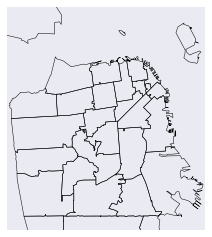

In [124]:
from shapely.geometry import box

shp = fiona.open(SFshapefile + '.shp')
bds = shp.bounds
shp.close()
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra=0.01
m = Basemap(projection='tmerc',
            lon_0=SFcenter[0],
            lat_0=SFcenter[1],
#                 ellps='spher
            llcrnrlon=coords[0] - extra * w,
            llcrnrlat=coords[1] - extra + 0.01 * h,
            urcrnrlon=coords[2] + extra * w,
            urcrnrlat=coords[3] + extra + 0.01 * h,
            lat_ts=0,
            resolution='i')
m.readshapefile(state,
                'SF',
                color='black',
                zorder=2)

In [125]:
m.SF_info

[{'RINGNUM': 1,
  'SHAPENUM': 1,
  'area': 12313263537.0,
  'length': 995176.225313,
  'po_name': 'NAPA',
  'state': 'CA',
  'zip': '94558'},
 {'RINGNUM': 2,
  'SHAPENUM': 1,
  'area': 12313263537.0,
  'length': 995176.225313,
  'po_name': 'NAPA',
  'state': 'CA',
  'zip': '94558'},
 {'RINGNUM': 1,
  'SHAPENUM': 2,
  'area': 7236949520.92,
  'length': 441860.2014,
  'po_name': 'DIXON',
  'state': 'CA',
  'zip': '95620'},
 {'RINGNUM': 1,
  'SHAPENUM': 3,
  'area': 3001414164.85,
  'length': 311318.546326,
  'po_name': 'SONOMA',
  'state': 'CA',
  'zip': '95476'},
 {'RINGNUM': 1,
  'SHAPENUM': 4,
  'area': 1194301744.88,
  'length': 359104.646602,
  'po_name': 'NAPA',
  'state': 'CA',
  'zip': '94559'},
 {'RINGNUM': 1,
  'SHAPENUM': 5,
  'area': 991786103.42,
  'length': 200772.556587,
  'po_name': 'FAIRFIELD',
  'state': 'CA',
  'zip': '94533'},
 {'RINGNUM': 1,
  'SHAPENUM': 6,
  'area': 2006544443.06,
  'length': 267474.490552,
  'po_name': 'PETALUMA',
  'state': 'CA',
  'zip': '94954'

['Seacliff',
 'Lake Street',
 'Presidio National Park',
 'Presidio Terrace',
 'Inner Richmond',
 'Sutro Heights',
 'Lincoln Park / Ft. Miley',
 'Outer Richmond',
 'Golden Gate Park',
 'Presidio Heights',
 'Laurel Heights / Jordan Park',
 'Lone Mountain',
 'Anza Vista',
 'Cow Hollow',
 'Union Street',
 'Marina',
 'Telegraph Hill',
 'Downtown / Union Square',
 'Tenderloin',
 'Civic Center',
 'Hayes Valley',
 'Alamo Square',
 'Panhandle',
 'Haight Ashbury',
 'Lower Haight',
 'Mint Hill',
 'Duboce Triangle',
 'Cole Valley',
 'Rincon Hill',
 'South Beach',
 'South of Market',
 'Showplace Square',
 'Mission Bay',
 'Yerba Buena Island',
 'Treasure Island',
 'Mission Dolores',
 'Castro',
 'Outer Sunset',
 'Parkside',
 'Stonestown',
 'Parkmerced',
 'Lakeshore',
 'Golden Gate Heights',
 'Forest Hill',
 'West Portal',
 'Clarendon Heights',
 'Midtown Terrace',
 'Laguna Honda',
 'Upper Market',
 'Dolores Heights',
 'Mission',
 'Potrero Hill',
 'Dogpatch',
 'Central Waterfront',
 'Diamond Heights',


In [35]:
from pysal.esda.mapclassify import Natural_Breaks
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

def prep_df(df, W, labels):
    W_df= W = pd.DataFrame(W)
    for col in W.columns:
        W.loc[:,col] = Natural_Breaks(W.loc[:, col], k=10).yb
    df['class'] = labels + 1
    df = pd.concat((df.drop(range(1,11), axis=1), W), axis=1)
    df['ZIP'] = df['ZIP'].apply(int).apply(str)
    return df

def get_df_map(df):
    df_map = pd.DataFrame({
            'poly': [Polygon(xy) for xy in m.LA],
            'zipcode': [ward['zipcode'] for ward in m.LA_info]})
    df_map = pd.merge(df_map, df, how='left', left_on='zipcode', right_on='ZIP',
                      left_index=True, right_index=False)
    df_map = df_map.fillna(0)
    df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1.0, zorder=4))
#     print df_map.head()
    return df_map

def build_yr_map_nmf(df_map):
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='w', frame_on=False)
    # draw wards with grey outlines
    norm = Normalize()
    cmaps = []
    colors = ['Blues', 'Greens', 'Oranges', 'Reds', 'Purples']
    for i in xrange(5):
        color = colors[i]
        cmap = plt.get_cmap(color)
        pc = PatchCollection(df_map[df_map['class'] == i+1]['patches'], match_original=True, alpha=0.8)
        pc.set_facecolor(cmap(norm(df_map.loc[(df_map['class'] == i+1), i].values)))
        ax.add_collection(pc)
    pc = PatchCollection(df_map[df_map['class'] == 0]['patches'], match_original=True, alpha=0.3)
    pc.set_facecolor('Grey')
    ax.add_collection(pc)
    info = 'LA Commuties Categoried by Crime -- {}'.format(yr)

    # Draw a map scale
    m.drawmapscale(
        coords[0] + 0.2, coords[1] + 1.015,
        coords[0], coords[1],
        20.,
        barstyle='fancy', labelstyle='simple',
        fillcolor1='w', fillcolor2='#555555',
        fontcolor='#555555', units='mi',
        zorder=5)
    # this will set the image width to 722px at 100dpi
    plt.tight_layout()
    fig.set_size_inches(12, 16)
    # plt.savefig('data/london_plaques.png', dpi=100, alpha=True)
    plt.show()

In [36]:
new_df = prep_df(sfdf, W, labelsNMF)
for yr in xrange(2003, 2016):
    df_map = get_df_map(new_df[new_df['Year'] == yr])
    build_yr_map_nmf(df_map)

ValueError: labels [8] not contained in axis

In [87]:
sfdf['zipcode'].unique().shape

(29,)